In [4]:
model_output_dir = '/home/b09901066/trl/model_output/1217-2151'
# model_output_dir = '/home/b09901066/trl/model_output/1218-1354'

### CLAPS (Train + Test Data)

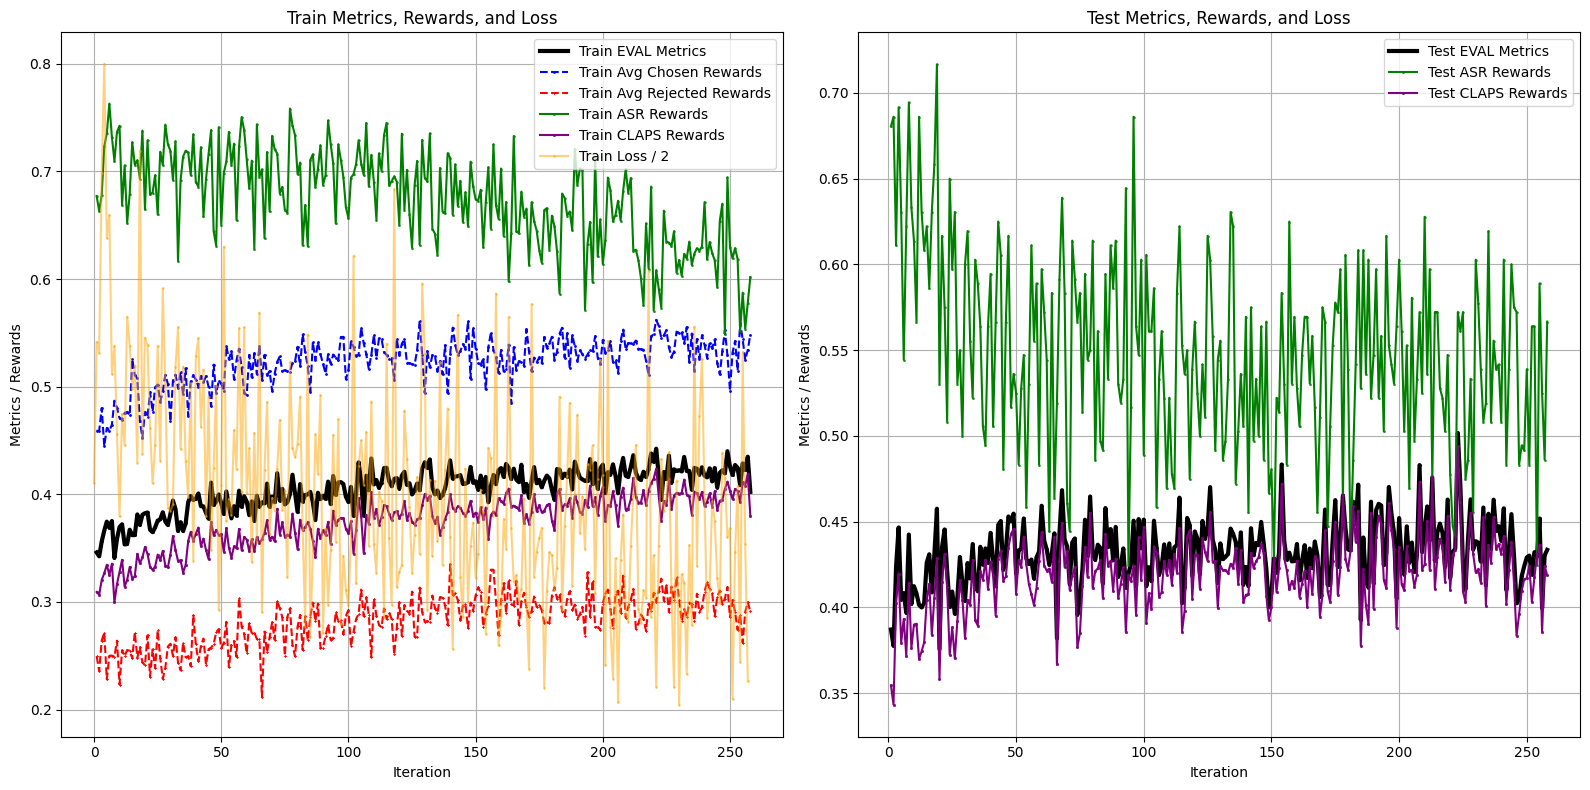

In [5]:
import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Log file path
log_path = f'{model_output_dir}/log_training.log'

# Utility Functions
def pooled_std_dev(std_devs, counts):
    """Calculate the pooled standard deviation."""
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))
    return np.sqrt(numerator / denominator) if denominator > 0 else 0

def parse_rewards_from_pattern(log_path, pattern, parse_value_fn):
    """Generalized function to parse rewards from a log file based on a pattern."""
    rewards = {}
    current_iteration = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if "Starting iteration" in line:
                current_iteration = int(re.search(r"iteration (\d+)", line).group(1)) + 1
            match = pattern.search(line)
            if match and current_iteration is not None:
                rewards[current_iteration] = parse_value_fn(match)

    return rewards

def parse_metric_list(metrics_string):
    """Safely convert a metrics string to a Python object."""
    try:
        metrics_string = (
            metrics_string.replace("np.float64", "")
            .replace("(", "")
            .replace(")", "")
            .replace("'", '"')  # Ensure JSON compatibility
        )
        return ast.literal_eval(metrics_string)
    except Exception as e:
        print(f"Failed to parse metrics string: {metrics_string}\nError: {e}")
        return []

def parse_log_file(log_path, data_type):
    """Parse log file to extract evaluation metrics for Train or Test set."""
    eval_pattern = re.compile(rf"EVAL: Cosine_Sim metrics {data_type} Set for iteration (\d+): (.+)")
    original_model_pattern = re.compile(rf"Original model metrics on {data_type} set: (.+)")

    data = {"EVAL": {}, "Original": []}

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if eval_match := eval_pattern.search(line):
                iteration = int(eval_match.group(1)) + 1
                metrics_list = parse_metric_list(eval_match.group(2).strip())
                if not metrics_list:
                    print(f"Skipping invalid EVAL data for iteration {iteration}.")
                    continue

                means, std_devs, counts = [], [], []
                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        count = len(metrics['metrics']['rewards'])
                        means.append(mean)
                        std_devs.append(std_dev)
                        counts.append(count)
                    except KeyError:
                        print(f"Skipping malformed metrics: {metrics}")
                        continue

                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts,
                }

            elif original_match := original_model_pattern.search(line):
                metrics_list = parse_metric_list(original_match.group(1).strip())
                if not metrics_list:
                    print(f"Skipping invalid Original model data for {data_type} set.")
                    continue

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        data["Original"].append((mean, std_dev))
                    except KeyError:
                        print(f"Skipping malformed Original metrics: {metrics}")
                        continue

    return data

def parse_chosen_rejected_rewards(log_path, data_type):
    """Parse the log file to extract chosen and rejected rewards."""
    chosen_pattern = re.compile(rf"Chosen rewards for iteration (\d+): (.+)")
    rejected_pattern = re.compile(rf"Rejected rewards for iteration (\d+): (.+)")

    def parse_rewards(rewards_string):
        try:
            return ast.literal_eval(rewards_string.strip())
        except Exception as e:
            print(f"Failed to parse rewards: {rewards_string}\nError: {e}")
            return []

    chosen_rewards = parse_rewards_from_pattern(log_path, chosen_pattern, lambda match: parse_rewards(match.group(2)))
    rejected_rewards = parse_rewards_from_pattern(log_path, rejected_pattern, lambda match: parse_rewards(match.group(2)))

    return chosen_rewards, rejected_rewards

def parse_asr_rewards(log_path, data_type):
    """Parse the log file to extract ASR rewards."""
    asr_pattern = re.compile(rf"EVAL: Trained model average ASR rewards on {data_type} set: (\d+\.\d+)")
    return parse_rewards_from_pattern(log_path, asr_pattern, lambda match: float(match.group(1)))

def parse_claps_rewards(log_path, data_type):
    """Parse the log file to extract CLAPS rewards."""
    claps_pattern = re.compile(rf"EVAL: Trained model average CLAPS rewards on {data_type} set: (\d+\.\d+)")
    return parse_rewards_from_pattern(log_path, claps_pattern, lambda match: float(match.group(1)))

def parse_original_model_rewards(log_path, data_type):
    """Parse the log file to extract Original Model rewards and ASR rewards."""
    original_pattern = re.compile(rf"Original model average rewards on {data_type} set: (\d+\.\d+)")
    asr_pattern = re.compile(rf"Original model average ASR rewards on {data_type} set: (\d+\.\d+)")

    original_rewards, original_asr_rewards = None, None
    with open(log_path, 'r') as log_file:
        for line in log_file:
            if original_match := original_pattern.search(line):
                original_rewards = float(original_match.group(1))
            if asr_match := asr_pattern.search(line):
                original_asr_rewards = float(asr_match.group(1))

    return original_rewards, original_asr_rewards

def parse_loss(log_path):
    """Parse the log file to extract loss per iteration."""
    loss_pattern = re.compile(r"Iteration: (\d+), Loss: ([0-9]*\.?[0-9]+)")
    losses = {}

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if loss_match := loss_pattern.search(line):
                iteration = int(loss_match.group(1))
                loss = float(loss_match.group(2))
                losses[iteration] = loss

    return losses

def plot_metrics(data_train, data_test, chosen_train, chosen_test, rejected_train, rejected_test, asr_train, asr_test, claps_train, claps_test, original_train, original_test, losses):
    """Plot Train and Test metrics with loss integrated into each subplot."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Two subplots: Train and Test

    # Iterate over Train and Test
    for i, (data, chosen, rejected, asr, claps, original, losses_subset, data_type) in enumerate([
        (data_train, chosen_train, rejected_train, asr_train, claps_train, original_train, losses, "Train"),
        (data_test, chosen_test, rejected_test, asr_test, claps_test, original_test, losses, "Test")
    ]):
        ax = axes[i]

        # Plot EVAL Metrics
        iterations = sorted(data["EVAL"].keys())
        avg_means = [np.mean(data["EVAL"][it]["means"]) for it in iterations]
        pooled_std_devs = [pooled_std_dev(data["EVAL"][it]["std_devs"], data["EVAL"][it]["counts"]) for it in iterations]
        ax.plot(iterations, avg_means, marker='o', linestyle='-', label=f'{data_type} EVAL Metrics', color='black', markersize=1, linewidth=3)

        # Plot chosen and rejected rewards
        all_iterations = sorted(set(chosen.keys()).union(rejected.keys()))
        avg_chosen = [np.mean(chosen.get(it, [])) for it in all_iterations]
        avg_rejected = [np.mean(rejected.get(it, [])) for it in all_iterations]
        if data_type == "Train":
            ax.plot(all_iterations, avg_chosen, marker='o', linestyle='--', label=f'{data_type} Avg Chosen Rewards', color='blue', markersize=1)
            ax.plot(all_iterations, avg_rejected, marker='x', linestyle='--', label=f'{data_type} Avg Rejected Rewards', color='red', markersize=1)

        # Plot ASR rewards
        asr_iterations = sorted(asr.keys())
        asr_values = [asr[it] for it in asr_iterations]
        ax.plot(asr_iterations, asr_values, marker='^', linestyle='-', label=f'{data_type} ASR Rewards', color='green', markersize=1)

        # Plot CLAPS rewards
        claps_iterations = sorted(claps.keys())
        claps_values = [claps[it] for it in claps_iterations]
        ax.plot(claps_iterations, claps_values, marker='s', linestyle='-', label=f'{data_type} CLAPS Rewards', color='purple', markersize=1)

        # Plot Loss
        loss_iterations = sorted(losses_subset.keys())
        loss_values = [losses_subset[it] / 2 for it in loss_iterations]
        if data_type == "Train":
            ax.plot(loss_iterations, loss_values, marker='d', linestyle='-', label=f'{data_type} Loss / 2', color='orange', markersize=1, alpha=0.5)

        # Plot Original Rewards
        if original[0] is not None:
            ax.scatter([0], [original[0]], color='darkorange', label=f'{data_type} Original Rewards', zorder=5)
        if original[1] is not None:
            ax.scatter([0], [original[1]], color='darkcyan', label=f'{data_type} Original ASR Rewards', zorder=5)

        # Labels and legend
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Metrics / Rewards')
        ax.set_title(f'{data_type} Metrics, Rewards, and Loss')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Main Execution
data_train = parse_log_file(log_path, "Train")
data_test = parse_log_file(log_path, "Test")
chosen_train, rejected_train = parse_chosen_rejected_rewards(log_path, "Train")
chosen_test, rejected_test = parse_chosen_rejected_rewards(log_path, "Test")
asr_train = parse_asr_rewards(log_path, "Train")
asr_test = parse_asr_rewards(log_path, "Test")
claps_train = parse_claps_rewards(log_path, "Train")
claps_test = parse_claps_rewards(log_path, "Test")
losses = parse_loss(log_path)
original_train = parse_original_model_rewards(log_path, "Train")
original_test = parse_original_model_rewards(log_path, "Test")

plot_metrics(data_train, data_test, chosen_train, chosen_test, rejected_train, rejected_test, asr_train, asr_test, claps_train, claps_test, original_train, original_test, losses)

### CLAPS (Test Data)

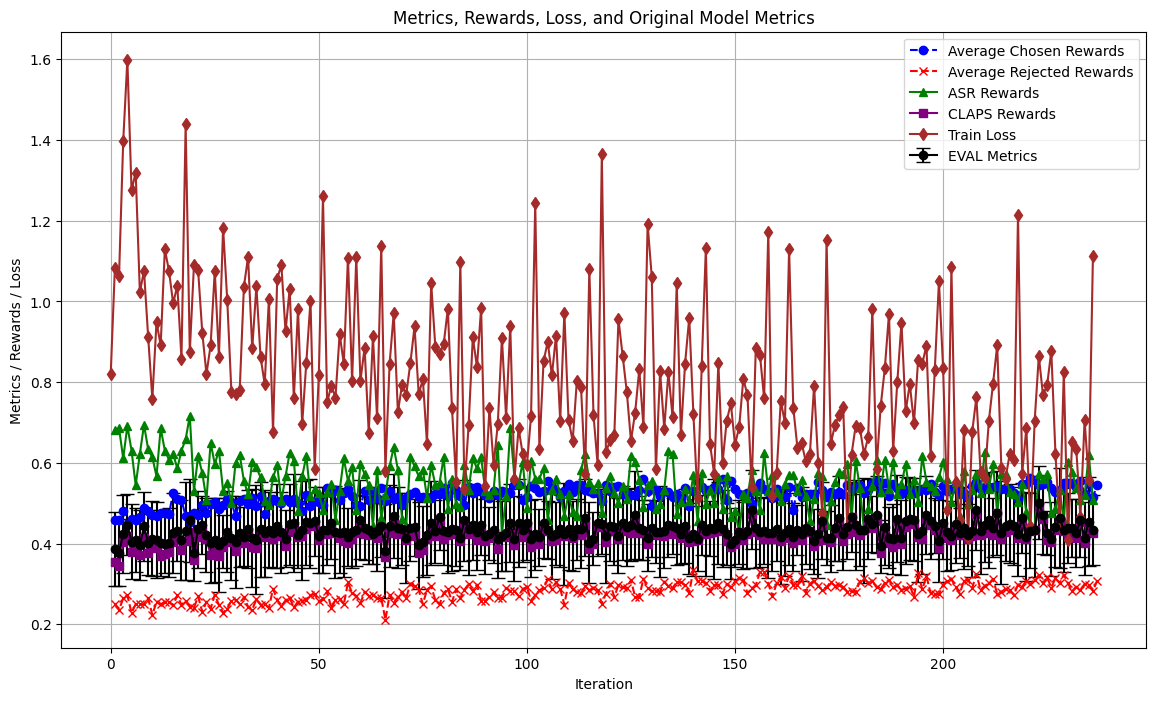

In [4]:
import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Log file path
log_path = f'{model_output_dir}/log_training.log'

# Utility Functions
def pooled_std_dev(std_devs, counts):
    """Calculate the pooled standard deviation."""
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))
    return np.sqrt(numerator / denominator) if denominator > 0 else 0

def parse_rewards_from_pattern(log_path, pattern, parse_value_fn):
    """Generalized function to parse rewards from a log file based on a pattern."""
    rewards = {}
    current_iteration = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if "Starting iteration" in line:
                current_iteration = int(re.search(r"iteration (\d+)", line).group(1)) + 1
            match = pattern.search(line)
            if match and current_iteration is not None:
                rewards[current_iteration] = parse_value_fn(match)

    return rewards

def parse_metric_list(metrics_string):
    """Safely convert a metrics string to a Python object."""
    try:
        metrics_string = (
            metrics_string.replace("np.float64", "")
            .replace("(", "")
            .replace(")", "")
            .replace("'", '"')  # Ensure JSON compatibility
        )
        return ast.literal_eval(metrics_string)
    except Exception as e:
        print(f"Failed to parse metrics string: {metrics_string}\nError: {e}")
        return []

# Parsing Functions
def parse_log_file(log_path):
    """Parse log file to extract evaluation metrics."""
    eval_pattern = re.compile(r"EVAL: Cosine_Sim metrics Test Set for iteration (\d+): (.+)")
    original_model_pattern = re.compile(r"Original model metrics on Test set: (.+)")

    data = {"EVAL": {}, "Original": []}

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if eval_match := eval_pattern.search(line):
                iteration = int(eval_match.group(1)) + 1
                metrics_list = parse_metric_list(eval_match.group(2).strip())
                if not metrics_list:
                    print(f"Skipping invalid EVAL data for iteration {iteration}.")
                    continue

                means, std_devs, counts = [], [], []
                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        count = len(metrics['metrics']['rewards'])
                        means.append(mean)
                        std_devs.append(std_dev)
                        counts.append(count)
                    except KeyError:
                        print(f"Skipping malformed metrics: {metrics}")
                        continue

                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts,
                }

            elif original_match := original_model_pattern.search(line):
                metrics_list = parse_metric_list(original_match.group(1).strip())
                if not metrics_list:
                    print("Skipping invalid Original model data.")
                    continue

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        data["Original"].append((mean, std_dev))
                    except KeyError:
                        print(f"Skipping malformed Original metrics: {metrics}")
                        continue

    return data

def parse_chosen_rejected_rewards(log_path):
    """Parse the log file to extract chosen and rejected rewards."""
    chosen_pattern = re.compile(r"Chosen rewards for iteration (\d+): (.+)")
    rejected_pattern = re.compile(r"Rejected rewards for iteration (\d+): (.+)")

    def parse_rewards(rewards_string):
        try:
            return ast.literal_eval(rewards_string.strip())
        except Exception as e:
            print(f"Failed to parse rewards: {rewards_string}\nError: {e}")
            return []

    chosen_rewards = parse_rewards_from_pattern(log_path, chosen_pattern, lambda match: parse_rewards(match.group(2)))
    rejected_rewards = parse_rewards_from_pattern(log_path, rejected_pattern, lambda match: parse_rewards(match.group(2)))

    return chosen_rewards, rejected_rewards

def parse_asr_rewards(log_path):
    """Parse the log file to extract ASR rewards."""
    asr_pattern = re.compile(r"EVAL: Trained model average ASR rewards on Test set: (\d+\.\d+)")
    return parse_rewards_from_pattern(log_path, asr_pattern, lambda match: float(match.group(1)))

def parse_claps_rewards(log_path):
    """Parse the log file to extract CLAPS rewards."""
    claps_pattern = re.compile(r"EVAL: Trained model average CLAPS rewards on Test set: (\d+\.\d+)")
    return parse_rewards_from_pattern(log_path, claps_pattern, lambda match: float(match.group(1)))

def parse_original_model_rewards(log_path):
    """Parse the log file to extract Original Model rewards and ASR rewards."""
    original_pattern = re.compile(r"Original model average rewards on Test set: (\d+\.\d+)")
    asr_pattern = re.compile(r"Original model average ASR rewards on Test set: (\d+\.\d+)")

    original_rewards, original_asr_rewards = None, None
    with open(log_path, 'r') as log_file:
        for line in log_file:
            if original_match := original_pattern.search(line):
                original_rewards = float(original_match.group(1))
            if asr_match := asr_pattern.search(line):
                original_asr_rewards = float(asr_match.group(1))

    return original_rewards, original_asr_rewards

def parse_train_loss(log_path):
    """Parse the log file to extract train loss."""
    train_loss_pattern = re.compile(r"Iteration: (\d+), Loss: ([\d\.]+)")
    train_loss = {}

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if train_loss_match := train_loss_pattern.search(line):
                iteration = int(train_loss_match.group(1))
                loss = float(train_loss_match.group(2))
                train_loss[iteration] = loss

    return train_loss

# Plot Function
def plot_all_metrics(data, chosen_rewards, rejected_rewards, asr_rewards, claps_rewards, original_rewards, original_asr_rewards, train_loss):
    """Plot all metrics, including train_loss."""
    plt.figure(figsize=(14, 8))

    # Plot EVAL Metrics
    iterations = sorted(data["EVAL"].keys())
    avg_means = [np.mean(data["EVAL"][it]["means"]) for it in iterations]
    pooled_std_devs = [pooled_std_dev(data["EVAL"][it]["std_devs"], data["EVAL"][it]["counts"]) for it in iterations]

    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='EVAL Metrics', color='black')

    # Plot chosen and rejected rewards
    all_iterations = sorted(set(chosen_rewards.keys()).union(rejected_rewards.keys()))
    avg_chosen = [np.mean(chosen_rewards.get(it, [])) for it in all_iterations]
    avg_rejected = [np.mean(rejected_rewards.get(it, [])) for it in all_iterations]

    plt.plot(all_iterations, avg_chosen, marker='o', linestyle='--', label='Average Chosen Rewards', color='blue')
    plt.plot(all_iterations, avg_rejected, marker='x', linestyle='--', label='Average Rejected Rewards', color='red')

    # Plot ASR rewards
    asr_iterations = sorted(asr_rewards.keys())
    asr_values = [asr_rewards[it] for it in asr_iterations]
    plt.plot(asr_iterations, asr_values, marker='^', linestyle='-', label='ASR Rewards', color='green')

    # Plot CLAPS rewards
    claps_iterations = sorted(claps_rewards.keys())
    claps_values = [claps_rewards[it] for it in claps_iterations]
    plt.plot(claps_iterations, claps_values, marker='s', linestyle='-', label='CLAPS Rewards', color='purple')

    # Plot Train Loss
    if train_loss:
        train_loss_iterations = sorted(train_loss.keys())
        train_loss_values = [train_loss[it] for it in train_loss_iterations]
        plt.plot(train_loss_iterations, train_loss_values, marker='d', linestyle='-', label='Train Loss', color='brown')

    # Plot Original Model rewards and ASR
    if original_rewards is not None:
        plt.scatter([0], [original_rewards], color='darkorange', label='Original Model Rewards', zorder=5)
    if original_asr_rewards is not None:
        plt.scatter([0], [original_asr_rewards], color='darkcyan', label='Original Model ASR Rewards', zorder=5)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Metrics / Rewards / Loss')
    plt.title('Metrics, Rewards, Loss, and Original Model Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
# Main Execution
data = parse_log_file(log_path)
chosen_rewards, rejected_rewards = parse_chosen_rejected_rewards(log_path)
asr_rewards = parse_asr_rewards(log_path)
claps_rewards = parse_claps_rewards(log_path)
original_rewards, original_asr_rewards = parse_original_model_rewards(log_path)
train_loss = parse_train_loss(log_path)

plot_all_metrics(data, chosen_rewards, rejected_rewards, asr_rewards, claps_rewards, original_rewards, original_asr_rewards, train_loss)


### CLAPS (Train Data)

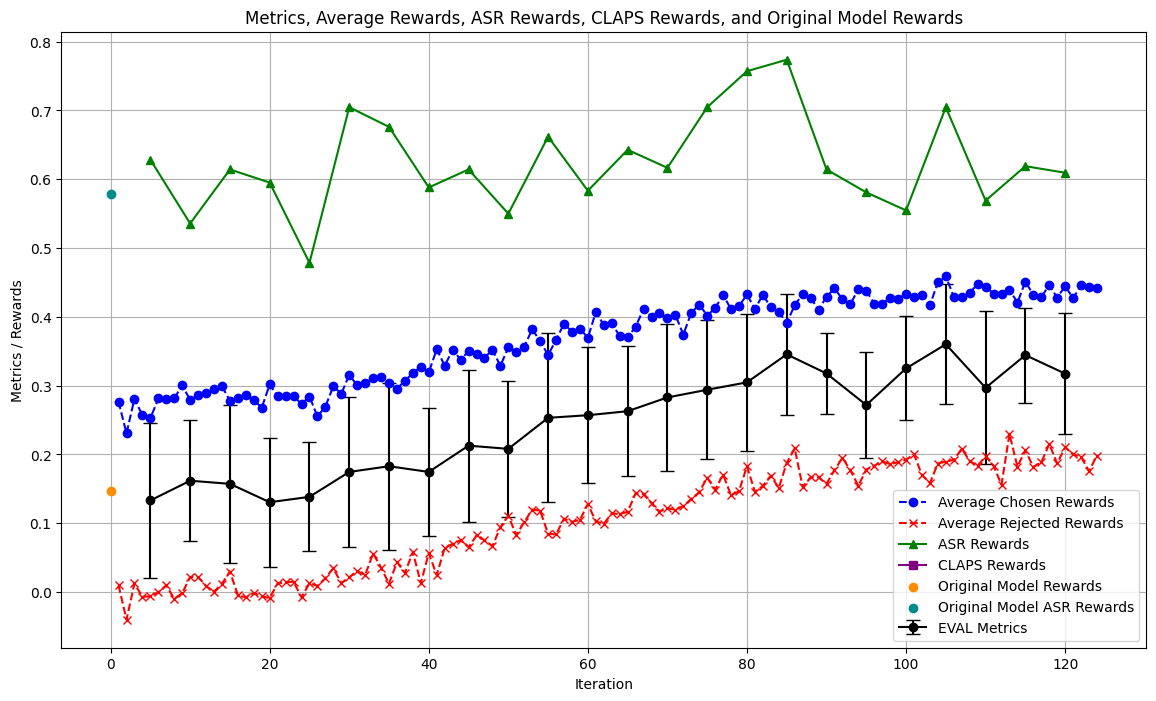

In [3]:
import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Log file path
log_path = f'{model_output_dir}/log_training.log'

# Utility Functions
def pooled_std_dev(std_devs, counts):
    """Calculate the pooled standard deviation."""
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))
    return np.sqrt(numerator / denominator) if denominator > 0 else 0

def parse_rewards_from_pattern(log_path, pattern, parse_value_fn):
    """Generalized function to parse rewards from a log file based on a pattern."""
    rewards = {}
    current_iteration = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if "Starting iteration" in line:
                current_iteration = int(re.search(r"iteration (\d+)", line).group(1)) + 1
            match = pattern.search(line)
            if match and current_iteration is not None:
                rewards[current_iteration] = parse_value_fn(match)

    return rewards

def parse_metric_list(metrics_string):
    """Safely convert a metrics string to a Python object."""
    try:
        metrics_string = (
            metrics_string.replace("np.float64", "")
            .replace("(", "")
            .replace(")", "")
            .replace("'", '"')  # Ensure JSON compatibility
        )
        return ast.literal_eval(metrics_string)
    except Exception as e:
        print(f"Failed to parse metrics string: {metrics_string}\nError: {e}")
        return []

# Parsing Functions
def parse_log_file(log_path):
    """Parse log file to extract evaluation metrics."""
    eval_pattern = re.compile(r"EVAL: Cosine_Sim metrics Train Set for iteration (\d+): (.+)")
    original_model_pattern = re.compile(r"Original model metrics on Train set: (.+)")

    data = {"EVAL": {}, "Original": []}

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if eval_match := eval_pattern.search(line):
                iteration = int(eval_match.group(1)) + 1
                metrics_list = parse_metric_list(eval_match.group(2).strip())
                if not metrics_list:
                    print(f"Skipping invalid EVAL data for iteration {iteration}.")
                    continue

                means, std_devs, counts = [], [], []
                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        count = len(metrics['metrics']['rewards'])
                        means.append(mean)
                        std_devs.append(std_dev)
                        counts.append(count)
                    except KeyError:
                        print(f"Skipping malformed metrics: {metrics}")
                        continue

                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts,
                }

            elif original_match := original_model_pattern.search(line):
                metrics_list = parse_metric_list(original_match.group(1).strip())
                if not metrics_list:
                    print("Skipping invalid Original model data.")
                    continue

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        data["Original"].append((mean, std_dev))
                    except KeyError:
                        print(f"Skipping malformed Original metrics: {metrics}")
                        continue

    return data

def parse_chosen_rejected_rewards(log_path):
    """Parse the log file to extract chosen and rejected rewards."""
    chosen_pattern = re.compile(r"Chosen rewards for iteration (\d+): (.+)")
    rejected_pattern = re.compile(r"Rejected rewards for iteration (\d+): (.+)")

    def parse_rewards(rewards_string):
        try:
            return ast.literal_eval(rewards_string.strip())
        except Exception as e:
            print(f"Failed to parse rewards: {rewards_string}\nError: {e}")
            return []

    chosen_rewards = parse_rewards_from_pattern(log_path, chosen_pattern, lambda match: parse_rewards(match.group(2)))
    rejected_rewards = parse_rewards_from_pattern(log_path, rejected_pattern, lambda match: parse_rewards(match.group(2)))

    return chosen_rewards, rejected_rewards

def parse_asr_rewards(log_path):
    """Parse the log file to extract ASR rewards."""
    asr_pattern = re.compile(r"EVAL: Trained model average ASR rewards on Train set: (\d+\.\d+)")
    return parse_rewards_from_pattern(log_path, asr_pattern, lambda match: float(match.group(1)))

def parse_claps_rewards(log_path):
    """Parse the log file to extract CLAPS rewards."""
    claps_pattern = re.compile(r"EVAL: Trained model average CLAPS rewards on Train set: (\d+\.\d+)")
    return parse_rewards_from_pattern(log_path, claps_pattern, lambda match: float(match.group(1)))

def parse_original_model_rewards(log_path):
    """Parse the log file to extract Original Model rewards and ASR rewards."""
    original_pattern = re.compile(r"Original model average rewards on Train set: (\d+\.\d+)")
    asr_pattern = re.compile(r"Original model average ASR rewards on Train set: (\d+\.\d+)")

    original_rewards, original_asr_rewards = None, None
    with open(log_path, 'r') as log_file:
        for line in log_file:
            if original_match := original_pattern.search(line):
                original_rewards = float(original_match.group(1))
            if asr_match := asr_pattern.search(line):
                original_asr_rewards = float(asr_match.group(1))

    return original_rewards, original_asr_rewards

# Plot Function
def plot_all_metrics(data, chosen_rewards, rejected_rewards, asr_rewards, claps_rewards, original_rewards, original_asr_rewards):
    """Plot all metrics on the same figure."""
    plt.figure(figsize=(14, 8))

    # Plot EVAL Metrics
    iterations = sorted(data["EVAL"].keys())
    avg_means = [np.mean(data["EVAL"][it]["means"]) for it in iterations]
    pooled_std_devs = [pooled_std_dev(data["EVAL"][it]["std_devs"], data["EVAL"][it]["counts"]) for it in iterations]

    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='EVAL Metrics', color='black')

    # Plot chosen and rejected rewards
    all_iterations = sorted(set(chosen_rewards.keys()).union(rejected_rewards.keys()))
    avg_chosen = [np.mean(chosen_rewards.get(it, [])) for it in all_iterations]
    avg_rejected = [np.mean(rejected_rewards.get(it, [])) for it in all_iterations]

    plt.plot(all_iterations, avg_chosen, marker='o', linestyle='--', label='Average Chosen Rewards', color='blue')
    plt.plot(all_iterations, avg_rejected, marker='x', linestyle='--', label='Average Rejected Rewards', color='red')

    # Plot ASR rewards
    asr_iterations = sorted(asr_rewards.keys())
    asr_values = [asr_rewards[it] for it in asr_iterations]
    plt.plot(asr_iterations, asr_values, marker='^', linestyle='-', label='ASR Rewards', color='green')

    # Plot CLAPS rewards
    claps_iterations = sorted(claps_rewards.keys())
    claps_values = [claps_rewards[it] for it in claps_iterations]
    plt.plot(claps_iterations, claps_values, marker='s', linestyle='-', label='CLAPS Rewards', color='purple')

    # Plot Original Model rewards and ASR
    if original_rewards is not None:
        plt.scatter([0], [original_rewards], color='darkorange', label='Original Model Rewards', zorder=5)
    if original_asr_rewards is not None:
        plt.scatter([0], [original_asr_rewards], color='darkcyan', label='Original Model ASR Rewards', zorder=5)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Metrics / Rewards')
    plt.title('Metrics, Average Rewards, ASR Rewards, CLAPS Rewards, and Original Model Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
data = parse_log_file(log_path)
chosen_rewards, rejected_rewards = parse_chosen_rejected_rewards(log_path)
asr_rewards = parse_asr_rewards(log_path)
claps_rewards = parse_claps_rewards(log_path)
original_rewards, original_asr_rewards = parse_original_model_rewards(log_path)

plot_all_metrics(data, chosen_rewards, rejected_rewards, asr_rewards, claps_rewards, original_rewards, original_asr_rewards)
